In [32]:
import os
import os.path as osp
import pickle
import time
from typing import NamedTuple
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from mujoco_py import const
import wrappers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import torch
import torch.nn.functional as F
import copy

from garage import EpisodeBatch
import torch
from torch import nn
from torchsummary import summary_string

# import dowel
# from dowel import logger, tabular
import gym

from garage.torch.modules import MLPModule
torch.set_num_threads(4)

import wandb

In [43]:
class Testaroo(NamedTuple):
    a: str
    b: int
    
    def __new__(cls, a, b):
        if not isinstance(a, str):
            raise ValueError()
        if not isinstance(b, int):
            raise ValueError()
        

AttributeError: Cannot overwrite NamedTuple attribute __new__

In [33]:
class ValidationSet(NamedTuple):
    episodes: EpisodeBatch
    env: gym.Env

In [38]:
class MLPRewardPredictor(nn.Module):
    """Gaussian MLP Value Function with Model.
    It fits the input data to a gaussian distribution estimated by
    a MLP.
    Args:
        env_spec (EnvSpec): Environment specification.
        hidden_sizes (list[int]): Output dimension of dense layer(s) for
            the MLP for mean. For example, (32, 32) means the MLP consists
            of two hidden layers, each with 32 hidden units.
        hidden_nonlinearity (callable): Activation function for intermediate
            dense layer(s). It should return a torch.Tensor. Set it to
            None to maintain a linear activation.
        hidden_w_init (callable): Initializer function for the weight
            of intermediate dense layer(s). The function should return a
            torch.Tensor.
        hidden_b_init (callable): Initializer function for the bias
            of intermediate dense layer(s). The function should return a
            torch.Tensor.
        output_nonlinearity (callable): Activation function for output dense
            layer. It should return a torch.Tensor. Set it to None to
            maintain a linear activation.
        output_w_init (callable): Initializer function for the weight
            of output dense layer(s). The function should return a
            torch.Tensor.
        output_b_init (callable): Initializer function for the bias
            of output dense layer(s). The function should return a
            torch.Tensor.
        learn_std (bool): Is std trainable.
        init_std (float): Initial value for std.
            (plain value - not log or exponentiated).
        layer_normalization (bool): Bool for using layer normalization or not.
        name (str): The name of the value function.
    """

    def __init__(self,
                 input_dim,
                 hidden_sizes=(32, 32),
                 hidden_nonlinearity=torch.tanh,
                 hidden_w_init=nn.init.xavier_uniform_,
                 hidden_b_init=nn.init.zeros_,
                 output_nonlinearity=None,
                 output_w_init=nn.init.xavier_uniform_,
                 output_b_init=nn.init.zeros_,
                 layer_normalization=False,
                 name='MLPRewardPredictor',
                ):

        super().__init__()

        output_dim = 1

        self.name = name
        
        self.module = MLPModule(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_sizes=hidden_sizes,
            hidden_nonlinearity=hidden_nonlinearity,
            hidden_w_init=hidden_w_init,
            hidden_b_init=hidden_b_init,
            output_nonlinearity=output_nonlinearity,
            output_w_init=output_w_init,
            output_b_init=output_b_init,
            layer_normalization=layer_normalization)

    def predict_preferences(self, left_segs, right_segs):
        if not left_segs.shape == right_segs.shape:
            raise ValueError('Left and Right segs should have the same shape')
        assert left_segs.ndim == 2
        
        batch_size, obs_dim = left_segs.shape

        left_out = self.module(left_segs)
        right_out = self.module(right_segs)
        logits = torch.cat([left_out, right_out], dim=1)
        
        preds = torch.argmax(logits, dim=1)
        return logits, preds


    # pylint: disable=arguments-differ
    def forward(self, obs):
        r"""Predict value based on paths.
        Args:
            obs (torch.Tensor): Observation from the environment
                with shape :math:`(P, O*)`.
        Returns:
            torch.Tensor: Calculated baselines given observations with
                shape :math:`(P, O*)`.
        """
        return self.module(obs)
    
    def predict(self,
                observations,):   
        with torch.no_grad():
            if len(observations) > 2048:
                i = 0
                pred_rewards = []
                while i <= len(observations):
                    start = i
                    end = i + 2048
                    batch_obs = observations[start:end]
                    pred_rewards.append(self.forward(batch_obs))
                    i += 2048
                pred_rewards = torch.cat(pred_rewards) 
            else:
                pred_rewards = self.forward(observations)
            return pred_rewards

    def validate(self,
                 validation_sets,
                 epoch,
                 visualize_flag=False):
        
        for name, val_set in validation_sets.items():
            env = val_set.env
            episodes = val_set.episodes
            space = env.spec.observation_space
            
            observations = np.array([space.flatten_with_keys(x, keys=['state']) for x in episodes.observations])
            observations = torch.tensor(observations.astype(np.float32))
            pred_rewards = reward_predictor.predict(observations)

            split_predictions = np.split(pred_rewards.detach().numpy().flatten(), np.cumsum(episodes.lengths)[:-1])

            corrs = []
            for pred_reward, gt_ep in zip(split_predictions, episodes.split()):
                corrs.append(np.corrcoef(pred_reward, gt_ep.env_infos['gt_reward'])[0,1])
            
            wandb.log({f'AvgEpisodeCorrelation-{name}': np.mean(corrs)}, step=epoch)
            
            if visualize_flag:
                scaled_rewards = scale_rewards(pred_rewards[::10])
                render = visualize(env, episodes.env_infos['state'][::10], scaled_rewards)
                wandb.log({f'RewardVisualization-{name}': wandb.Image(render)}, step=epoch)
    
    
    def train(self, 
              env, 
              observations,
              rewards,
              validation_sets=None,
              validation_freq=50,
              visualize_freq=200,
              batch_size=256,
              epochs=1000):
        
        assert visualize_freq % validation_freq == 0
        
        observations = torch.tensor(observations.astype(np.float32))
        
        total_ordering = np.argsort(rewards)

        pref_generator = PreferenceGenerator(observations[total_ordering], batch_size=batch_size)

        optimizer = torch.optim.Adam(reward_predictor.parameters(), lr=0.001)

        for epoch in range(epochs):
            correct = 0
            total = 0

            for left_segs, right_segs, prefs in pref_generator.get_minibatch():
                optimizer.zero_grad()
                logits, preds = self.predict_preferences(left_segs, right_segs)

                correct += torch.sum(preds.flatten() == prefs.flatten())
                total += len(preds)
                loss = nn.functional.cross_entropy(logits, prefs)      
                loss.backward()
                optimizer.step()
            
            accuracy = correct / total
            
#             wandb.log({'accuracy': accuracy}, step=epoch)
            wandb.log({'accuracy': accuracy}, commit=False)
            wandb.log(data={}, step=epoch, commit=True)
            
            if (validation_sets is not None) and epoch and (epoch % validation_freq == 0):
                visualize_flag = (epoch % visualize_freq == 0)
                self.validate(validation_sets, epoch, visualize_flag)


class PreferenceGenerator:
    
    def __init__(self, ordered_states, batch_size=256):
        self.ordered_states = ordered_states
        self.batch_size = batch_size
        self.update()
        
    def update(self):
        length = len(self.ordered_states)
        mid = length // 2
        permutation = np.random.permutation(length)
        self._left_ids = permutation[:mid]
        self._right_ids = permutation[mid:2*mid]
        self._prefs = torch.tensor((self._right_ids > self._left_ids).astype(int))
        self._num_batches = mid // self.batch_size
        
    def get_minibatch(self):
        for itr in range(self._num_batches):
            batch_start = itr * self.batch_size
            batch_end = (itr + 1) * self.batch_size
            left_ids = self._left_ids[batch_start: batch_end]
            right_ids = self._right_ids[batch_start: batch_end]
            prefs = self._prefs[batch_start: batch_end]
            left_segs = self.ordered_states[left_ids]
            right_segs = self.ordered_states[right_ids]
            yield left_segs, right_segs, prefs
        self.update()    

def get_pred_rewards(observations, reward_predictor):
    obs = torch.tensor(observations).type(torch.float32)

    pred_rewards = []
    i = 0
    while i < len(obs):
        start = i
        end = i + 2048

        pred_rewards.append(
            reward_predictor(obs[start:end])
        )

        i += 2048

    pred_rewards = torch.cat(pred_rewards)
    return pred_rewards

def scale_rewards(rewards):
    clipped_rewards = np.clip(rewards, -3, None)
    # clipped_rewards = pred_rewards
    scaled_rewards = (clipped_rewards - clipped_rewards.min())
    scaled_rewards /= scaled_rewards.max()
    return scaled_rewards

def convert_states(env, states):
    env.reset()
    positions = []
    observations = []
    for state in states:
        env.world.sim.set_state_from_flattened(state)
        obs = env.obs()
        positions.append(env.robot_pos)
        observations.append(obs)
    return observations, positions

def visualize(env, states, rewards=None):
    _, positions = convert_states(env, states)
        
    env.reset()
    env.render('rgb_array')
    
    if rewards is None:
        rewards = [0] * len(positions)
    
    for pos, reward in zip(positions, rewards):
        color = np.array([1-reward, reward, 0, 1])
        env.viewer.add_marker(pos=pos,
                              size=0.015 * np.ones(3),
                              type=const.GEOM_SPHERE,
                              rgba=color,
                              label='')

    render = env.render('rgb_array')
#     figure(figsize=(10,10))
#     plt.imshow(render)
    return render
    
def get_mesh_states(env, density=80):
    xys = np.mgrid[-1:4:density*1j,-2:2:density*1j].T.reshape(-1,2)
    env.reset()
    state = env.world.sim.get_state().flatten()
    states = []
    for x, y in xys:
        copied_state = copy.copy(state)
        copied_state[1] = x
        copied_state[2] = y
        states.append(copied_state)
    return states

def get_episodes(exps, epochs):  
    episodes = []    
    for exp in exps:
        for epoch in epochs:
            filename = osp.join('./experiment', exp, 'episode_logs', f'episode_{str(epoch)}.pkl')        
            with open(filename, 'rb') as f:
                episodes.append(pickle.load(f))
    episodes = EpisodeBatch.concatenate(*episodes)
    return episodes

In [4]:

# scaled_rewards = scale_rewards(eps.env_infos['gt_reward'])
# render = visualize(env, eps.env_infos['state'], scaled_rewards)

In [5]:

# scaled_rewards = scale_rewards(val_eps.env_infos['gt_reward'][::5])
# visualize(env, val_eps.env_infos['state'][::5], scaled_rewards)

In [6]:


# scaled_rewards = scale_rewards(reversed_eps.env_infos['gt_reward'][::5])
# visualize(reversed_env, reversed_eps.env_infos['state'][::5], scaled_rewards)

In [35]:
with open(osp.join('./experiment', 'DIVERSITY_ALPHA_05_Mon_Feb__1_09:36:50_2021', 'env.pkl'), 'rb') as f:
    env = pickle.load(f)
    
with open(osp.join('./experiment', 'DIVERSITY_RUN_0_Thu_Feb__4_13:04:03_2021', 'env.pkl'), 'rb') as f:
    reversed_env = pickle.load(f)

eps = get_episodes(['DIVERSITY_ALPHA_05_Mon_Feb__1_09:36:50_2021'], [200])
    
val_eps = get_episodes(
    exps=['DIVERSITY_RUN_0_Thu_Feb__4_07:46:02_2021', 'DIVERSITY_RUN_1_Thu_Feb__4_07:46:05_2021',
    'DIVERSITY_RUN_2_Thu_Feb__4_07:46:09_2021', 'DIVERSITY_RUN_3_Thu_Feb__4_07:46:11_2021'], 
    epochs=[200, 400])

reversed_eps = get_episodes(
    exps=['DIVERSITY_RUN_0_Thu_Feb__4_13:04:03_2021', 'DIVERSITY_RUN_1_Thu_Feb__4_13:04:06_2021',
    'DIVERSITY_RUN_2_Thu_Feb__4_13:04:13_2021', 'DIVERSITY_RUN_3_Thu_Feb__4_13:04:17_2021'], 
    epochs=[200])

space = env.spec.observation_space
skip = 40
observations = np.array([space.flatten_with_keys(x, keys=['state']) for x in eps.observations[::skip]])
rewards = eps.env_infos['gt_reward'][::skip]
assert len(observations) == len(rewards)

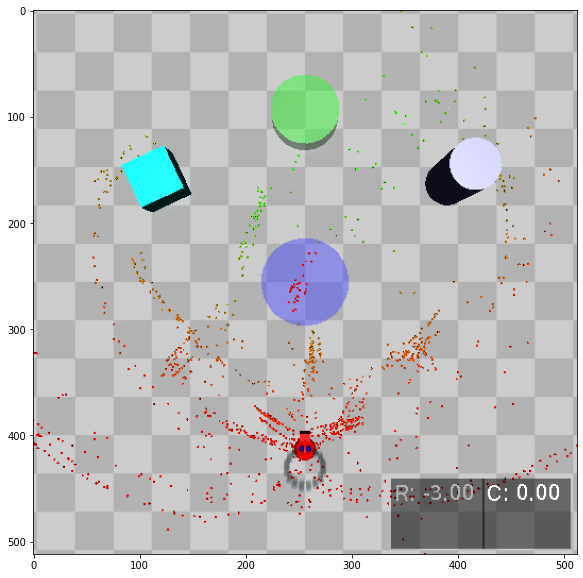

In [25]:
scaled_rewards = scale_rewards(eps.env_infos['gt_reward'][::skip])
render = visualize(env, eps.env_infos['state'][::skip], scaled_rewards)
figure(figsize=(10,10))
plt.imshow(render)

In [40]:
EXP_NAME = 'SMALL_TRAINING_SET_NAIVE_PREDICTOR' + '_' + time.ctime().replace(' ', '_')
LOG_DIR = f'./experiment/notebook_experiments/{EXP_NAME}'

reward_predictor = MLPRewardPredictor(
    input_dim=76,
    hidden_sizes=(256, 256),
#     layer_normalization=True,
    hidden_nonlinearity=F.relu,
)

summary, (total_params, trainable_params) = summary_string(reward_predictor, input_size=(76,), device=torch.device('cpu'))
NOTES = "MODEL SUMMARY:\n" + summary
NOTES += \
"""

Training on episodes collected form DIVERSITY_ALPHA_05_Mon_Feb__1_09:36:50_2021
Val episodes:
'DIVERSITY_RUN_0_Thu_Feb__4_07:46:02_2021', 'DIVERSITY_RUN_1_Thu_Feb__4_07:46:05_2021',
'DIVERSITY_RUN_2_Thu_Feb__4_07:46:09_2021', 'DIVERSITY_RUN_3_Thu_Feb__4_07:46:11_2021'

Reverse episodes:
'DIVERSITY_RUN_0_Thu_Feb__4_13:04:03_2021', 'DIVERSITY_RUN_1_Thu_Feb__4_13:04:06_2021',
'DIVERSITY_RUN_2_Thu_Feb__4_13:04:13_2021', 'DIVERSITY_RUN_3_Thu_Feb__4_13:04:17_2021'

Naive predictor, large dataset
"""


CONFIG = {
    'training_size': len(observations),
    'total_params': total_params,
    'trainable_params': trainable_params,
}

try:
    run.finish()
except:
    pass

run = wandb.init(
    project="Reward-Prediction-Comparisons",
    dir='../',
    notes=NOTES,
    config=CONFIG,
    name=EXP_NAME,
)

In [41]:
%%wandb 


reward_predictor.train(
    env,
    observations,
    rewards,
    validation_sets={'Validation': ValidationSet(val_eps, env), 'Reversed': ValidationSet(reversed_eps, reversed_env)})

torch.save(reward_predictor.state_dict(), './model.pt')
wandb.save('model.pt')

wandb: WARNING Step must only increase in log calls.  Step 50 < 51; dropping {'AvgEpisodeCorrelation-Validation': 0.48872675665081616}.
wandb: WARNING Step must only increase in log calls.  Step 50 < 51; dropping {'AvgEpisodeCorrelation-Reversed': 0.3557179073630119}.
wandb: WARNING Step must only increase in log calls.  Step 100 < 101; dropping {'AvgEpisodeCorrelation-Validation': 0.541508841073163}.
wandb: WARNING Step must only increase in log calls.  Step 100 < 101; dropping {'AvgEpisodeCorrelation-Reversed': 0.41125436372564084}.
wandb: WARNING Step must only increase in log calls.  Step 150 < 151; dropping {'AvgEpisodeCorrelation-Validation': 0.540843397334}.
wandb: WARNING Step must only increase in log calls.  Step 150 < 151; dropping {'AvgEpisodeCorrelation-Reversed': 0.4389077334469475}.


KeyboardInterrupt: 

In [42]:
run.finish()

accuracy,0.9375
_step,200
_runtime,15
_timestamp,1612589680


accuracy,▁▄▆▅▇▆▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇█▇▇▇█▇█████▇█
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▁▁▁▁▁▁▃▃▄▄▄▄▄▄▄▄▆▆▆▆▆▆▆▆▆▆██████████
_timestamp,▁▁▁▁▁▁▁▁▁▁▃▃▄▄▄▄▄▄▄▄▆▆▆▆▆▆▆▆▆▆██████████


In [71]:
mesh_states = get_mesh_states(env, density=100)
observations, positions = convert_states(env, mesh_states)
pred_rewards = get_pred_rewards(observations, reward_predictor)
scaled_rewards = scale_rewards(pred_rewards.detach().numpy())
visualize(env, mesh_states, scaled_rewards)

0.7670556171781532

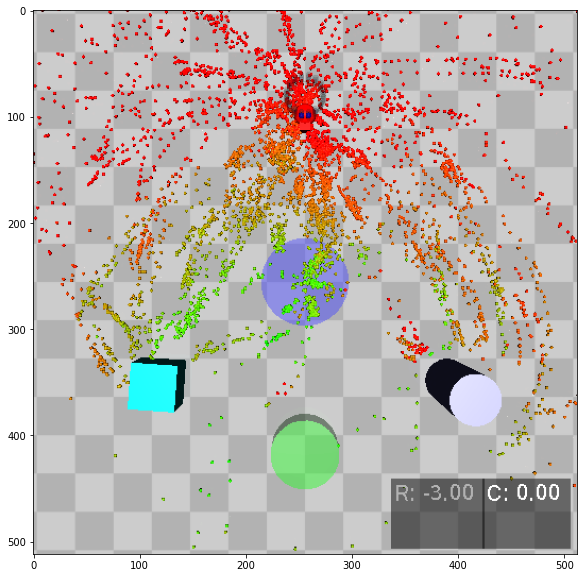

In [90]:
pred_rewards = get_pred_rewards([space.flatten_with_keys(x, keys=['state']) for x in reversed_episodes.observations][::40], reward_predictor)
scaled_rewards = scale_rewards(pred_rewards.detach().numpy())
visualize(reversed_env, reversed_episodes.env_infos['state'][::40], scaled_rewards)

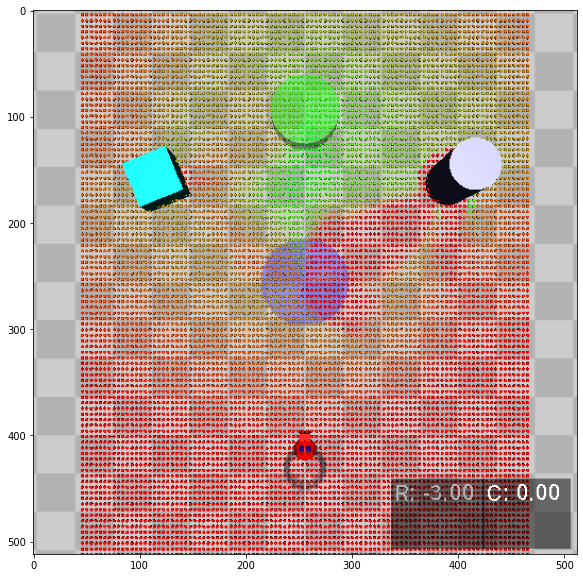